# Annotated Graphs

Make a graph for annotated data. The annotated data sets do not include time meta data so these need to be extracted of the json files.

See also the notebook annotation-graphs, which provides a more efficient implementation for hour-level time retrieval.

## 1. Read annotated data

In [1]:
import json
import pandas as pd
import re

In [2]:
TOPIC = "blij"
TOPIC_EN = {"blij": "happiness", "eenzaam": "loneliness"}[TOPIC]

if TOPIC == "distance":
    DATA_FILE = f"../{TOPIC}-tweets.csv"
elif TOPIC == "mondkapje":
    DATA_FILE = f"{TOPIC}-202003-202103-1000.csv"
elif TOPIC == "testing":
    DATA_FILE = f"{TOPIC}-202003-202012.csv"
elif TOPIC == "vaccin":
    DATA_FILE = f"{TOPIC}-202001-202101-1000.csv"
elif TOPIC == "eenzaam" or TOPIC == "blij":
    DATA_FILE = f"{TOPIC}_2020.csv"
else:
    assert False, f"unknown value for TOPIC: {TOPIC}"
DATA_DIR = "../data/annotation/"
LABEL_FILE = DATA_FILE + ".human-labels.txt"
data_file_no_directory = DATA_FILE.split("/")[-1]
TIME_FILE = "csv/time_data." + data_file_no_directory

In [3]:
data = pd.read_csv(DATA_DIR + DATA_FILE)
data.sort_values(by=['id_str'])
label_data_raw = pd.read_csv(DATA_DIR + LABEL_FILE, header=None, sep=" ")
label_data_raw.sort_values(by=[2])

label_data = {}
for row in label_data_raw.iterrows():
    annotator = row[1][0]
    id_str = row[1][2]
    label = row[1][4]
    if annotator == "erikt@xs4all.nl":
        label_data[id_str] = label

## 2. Checks and data write (skip)

In [4]:
len(data), len(label_data)

(620, 600)

In [ ]:
pd.Series(label_data).value_counts()/len(label_data)

In [ ]:
data.iloc[0]

In [ ]:
def make_doccano_data(data, label_data):
    doccano_data = []
    for i, row in data.iterrows():
        if row["id_str"] in label_data:
            doccano_data.append({ "id": row["id_str"], "label": label_data[row["id_str"]], "text": re.sub(r"\\n", " ", row["text"]) })
    return doccano_data

In [ ]:
def write_doccano_data(doccano_data, file_name):
    out_file = open(file_name, "w")
    for data in doccano_data:
        print(json.dumps(data), file=out_file)
    out_file.close()

In [ ]:
write_doccano_data(make_doccano_data(data, label_data), f"doccano_{TOPIC}.json")

In [ ]:
pd.DataFrame(make_doccano_data(data, label_data)).to_csv(f"{TOPIC}.csv", index=False)

## 3. Get time meta data (skip)

In [ ]:
import gzip
import json
import numpy as np
import os
import re
from IPython.display import clear_output

In [ ]:
JSON_DIR = "/home/erikt/media/20190525/files/cloud/twitter/2020"
FIRST_TWEET_IDS_FILE = "csv/first_tweet_ids.csv"

In [ ]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

In [ ]:
if False:
    first_tweet_ids = {}
    for month in range(1, 3+1):
        squeal(month)
        month_dir = JSON_DIR + str(month).zfill(2) + "/"
        file_names = sorted(os.listdir(month_dir))
        for file_name in file_names:
            infile = gzip.open(month_dir + file_name)
            line = infile.readline()
            infile.close()
            json_data = json.loads(line)
            first_tweet_ids[month_dir + file_name] = json_data['id_str']

In [ ]:
if False:
    pd.DataFrame([{"file_name": file_name, "id_str": first_tweet_ids[file_name]} for file_name in first_tweet_ids]).to_csv(FIRST_TWEET_IDS_FILE, index=False)

In [ ]:
first_tweet_ids = pd.read_csv(FIRST_TWEET_IDS_FILE).to_dict('records')

In [ ]:
first_tweet_ids_pointer = 0
try:
    time_data = pd.read_csv(TIME_FILE, index_col="id_str").to_dict(orient="series")['created_at']
except:
    time_data = {}
for row in data.iterrows():
    id_str = row[1]['id_str']
    if id_str in label_data.keys() and id_str not in time_data:
        id_str_found = False
        while first_tweet_ids[first_tweet_ids_pointer+1]['id_str'] < id_str and \
              first_tweet_ids_pointer < len(first_tweet_ids)-1:
            first_tweet_ids_pointer += 1
        while first_tweet_ids[first_tweet_ids_pointer]['id_str'] > id_str and first_tweet_ids_pointer > 0:
            first_tweet_ids_pointer -= 1
        #print(first_tweet_ids[first_tweet_ids_pointer]['file_name'])
        #print(id_str, first_tweet_ids[first_tweet_ids_pointer]['file_name'].split("/")[-1].split(".")[0])
        time_data[id_str] = first_tweet_ids[first_tweet_ids_pointer]['file_name'].split("/")[-1].split(".")[0]
        #infile = gzip.open(first_tweet_ids[first_tweet_ids_pointer]['file_name'])
        #for line in infile:
        #    json_data = json.loads(line)
        #    if json_data['id_str'] == str(id_str):
        #        time_data[json_data['id_str']] = json_data['created_at']
        #        squeal(json_data['created_at'])
        #        id_str_found = True
        #        break
        #infile.close()
        #if not id_str_found and first_tweet_ids_pointer > 0:
        #    first_tweet_ids_pointer -= 1
        #    infile = gzip.open(first_tweet_ids[first_tweet_ids_pointer]['file_name'])
        #    for line in infile:
        #        json_data = json.loads(line)
        #        if json_data['id_str'] == str(id_str):
        #            time_data[json_data['id_str']] = json_data['created_at']
        #            squeal(json_data['created_at'])
        #            id_str_found = True
        #            break
        #    infile.close()

In [ ]:
def file_date_to_json_date(file_date):
    return datetime.datetime.strftime(datetime.datetime.strptime(file_date, "%Y%m%d-%H"), "%a %b %d %H:%M:%S +0000 %Y")

In [ ]:
len(time_data.keys())

In [ ]:
pd.DataFrame([{'id_str': id_str, 'created_at': file_date_to_json_date(time_data[id_str])} 
              for id_str in time_data.keys()]).to_csv("csv/time_data." + data_file_no_directory, index=False)

## 4. Make graph

In [4]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib

In [5]:
data_file_no_directory = DATA_FILE.split("/")[-1]
TIME_FILE = "csv/time_data." + data_file_no_directory

In [6]:
time_data = pd.read_csv(TIME_FILE, index_col="id_str")

In [7]:
def make_graph_data_list(label_data, time_data):
    graph_data_dict = {}
    for id_str in label_data:
        label = label_data[id_str]
        if label == "EENS" or label == "ONEENS" or label == "RELEVANT":
            if id_str in time_data.index:
                graph_data_dict[id_str] = { "label": label, "created_at": time_data.loc[id_str]['created_at'] }
        elif label == "ANDERS" or label == "NEUTRAL" or label == "IRRELEVANT":
            if id_str in graph_data_dict:
                del(graph_data_dict[id_str])
        else:
            print(f"make_graph_data: cannot happen: {label}")
    return([{'label': graph_data_dict[id_str]['label'], 'created_at': graph_data_dict[id_str]['created_at']} for id_str in sorted(graph_data_dict.keys())])

In [8]:
N = 100


def percentage(window):
    total_count = 0
    support_count = 0
    for row in window:
        total_count += 1
        if row['label'] == "EENS":
            support_count += 1
    return(100 * support_count / total_count)


def select_graph_data(graph_data_list):
    window = []
    x = []
    y = []
    for i in range(0, len(graph_data_list)):
        window.append(graph_data_list[i])
        if len(window) >= N:
            selected_time_index = int((N-1)*(i-N+1)/(len(graph_data_list)-N+1))
            assert selected_time_index >= 0, f"select_graph_data: select_time_index {select_time_index} must be non-negative!"
            x.append(datetime.datetime.strptime(window[selected_time_index]['created_at'], "%a %b %d %H:%M:%S %z %Y"))
            y.append(percentage(window))
        while len(window) >= N:
            window.pop(0)
    return(x, y)

In [9]:
graph_data_list = make_graph_data_list(label_data, time_data)

In [10]:
x, y = select_graph_data(graph_data_list)

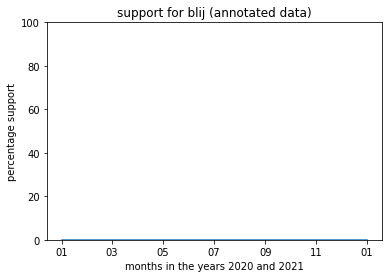

In [11]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
ax.plot_date(x, y, fmt="-")
plt.ylim(0, 100)
plt.xlabel("months in the years 2020 and 2021")
plt.ylabel("percentage support")
plt.title(f"support for {TOPIC} (annotated data)")
plt.savefig(f"annotated-{TOPIC}.png")
plt.show()

## 5. Make mood graph

In [12]:
def make_x_y(dates):
    data = {}
    for date in dates:
        month = date.month
        if month not in data:
            data[month] = 0
        data[month] += 1
    return [x for x in sorted(data.keys())], [data[x] for x in sorted(data.keys())]

In [13]:
relevant_data = { id_str: time_data.loc[id_str]['created_at'] for id_str in time_data.index if label_data[int(id_str)] == 'RELEVANT' }
irrelevant_data = { id_str: time_data.loc[id_str]['created_at'] for id_str in time_data.index if label_data[int(id_str)] == 'IRRELEVANT' }

In [14]:
dates_relevant = [datetime.datetime.strptime(relevant_data[id_str], "%a %b %d %H:%M:%S %z %Y") for id_str in relevant_data]
dates_irrelevant = [datetime.datetime.strptime(irrelevant_data[id_str], "%a %b %d %H:%M:%S %z %Y") for id_str in irrelevant_data]
x_relevant, y_relevant = make_x_y(dates_relevant)
x_irrelevant, y_irrelevant = make_x_y(dates_irrelevant)

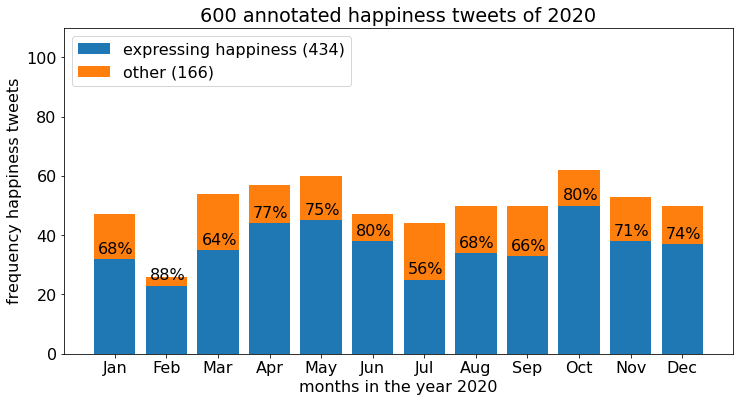

In [17]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

plt.figure(figsize=(12, 6))
plt.bar(x_relevant, y_relevant, label=f"expressing {TOPIC_EN} ({len(dates_relevant)})")
plt.bar(x_irrelevant, y_irrelevant, bottom=y_relevant, label=f"other ({len(dates_irrelevant)})")
for i in range(0, len(y_relevant)):
    plt.text(x_relevant[i] - 0.32, y_relevant[i] + 2, f"{int(100*y_relevant[i]/(y_relevant[i] + y_irrelevant[i]))}%")
plt.ylim([0, 110])
plt.xticks(range(1,13), [datetime.datetime(2020,m,1).strftime("%b") for m in range(1, 13)])
plt.xlabel("months in the year 2020")
plt.ylabel(f"frequency {TOPIC_EN} tweets")
plt.title(f"{len(label_data)} annotated {TOPIC_EN} tweets of 2020")
plt.legend(loc="upper left")
plt.savefig(f"annotated_freqs_{TOPIC_EN}.png")
plt.show()

In [18]:
month_counts_2020 = [ 15418685, 14851673, 21180942, 18715900, 18044679, 25944877,
                      21840960, 20314042, 20118797, 21987100, 19393478, 20249944 ]

In [19]:
def get_month_data(topic, year):
    hours_matched_list = pd.read_csv(f"csv/hours_matched_{year}_{topic}.csv", index_col=None).to_dict(orient="records")
    hours_matched = {}
    month_data = {}
    for row in hours_matched_list:
        month = row["hour"][4:6]
        if month not in month_data:
            month_data[month] = row["matched"]
        else:
            month_data[month] += row["matched"]
    return month_data

In [20]:
month_data = get_month_data(TOPIC, 2020)

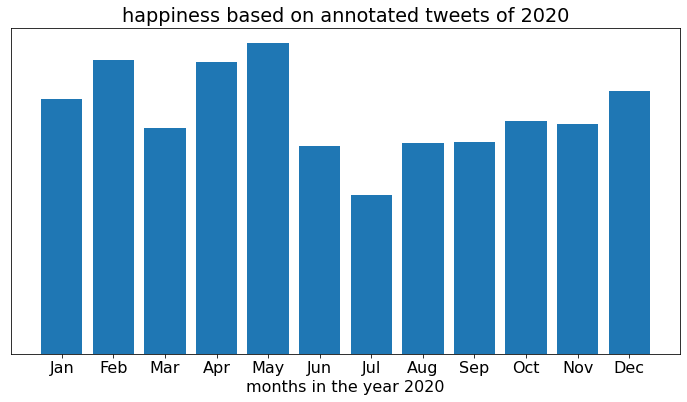

In [22]:
y_relative = [ (list(month_data.values())[i] * y_relevant[i]/(y_relevant[i] + y_irrelevant[i])) / month_counts_2020[i] 
               for i in range(0, len(y_relevant)) ]

plt.figure(figsize=(12, 6))
plt.bar(x_relevant, y_relative, label=f"expressing {TOPIC_EN}")
plt.xticks(range(1,13), [datetime.datetime(2020,m,1).strftime("%b") for m in range(1, 13)])
plt.yticks([])
plt.xlabel("months in the year 2020")
plt.title(f"{TOPIC_EN} based on annotated tweets of 2020")
plt.savefig(f"{TOPIC_EN}_annotated_2020.png")
plt.show()